In [11]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import random
FONT_SIZE = 18

In [3]:
path_pic = '../Pictures/'

# Create networks:
We will analyse the impact of targeted attacks of a real network, which is the network of protein-protein interactions in Saccharomyces cerevisiae (budding yeast). And extra two graph modell's examples, which are represented by an Erdős-Rényi graph and a Barabási-Albert graph. We know already, the scale-free networks are extremly robust against random node or link removals but they are very fragile when we start to remove the most important nodes of the network, they fall apart into smaller components. This is a huge problem if the most important property of the system is the connectedness. For example the Internet.

The first example network comes from a random graph model with the same number of nodes and the expected value of the number of edges in the real network.
$$  \langle L \rangle = p \cdot \frac{N(N-1)}{2}
$$


$$p = \frac{\langle L \rangle}{\frac{N(N-1)}{2}}
$$

The second network has the same degree sequence like the real network, which is comes from the configuration model.


The importance of a node is based on the next quantities:
* degree
* page rank
* local reaching centrality (within m = 3 steps)



In [53]:
# networks:
df_elist = pd.read_csv('CCSB-Y2H_edgelist_of_yeast_protein_protein.csv',
                       sep='\t',
                       names=["source", "target","type"])
network_yeast = nx.from_pandas_edgelist(df_elist,create_using=nx.Graph())




network_BA = nx.configuration_model(dict(network_yeast.degree()).values())
network_BA = nx.Graph(network_BA) # drop mutliedges

N = network_yeast.number_of_nodes()
p = network_yeast.number_of_edges() / (N*(N-1)/2)
network_ER = nx.generators.erdos_renyi_graph(N,p)




In [6]:
network_yeast.number_of_edges()

1809

In [7]:
network_yeast.number_of_nodes()

1278

In [8]:
network_ER.number_of_edges()

1767

In [9]:
network_ER.number_of_nodes()

1278

# Definitions:
The quantities that describe the fragmentation of the network are based on the size of the connected components.
* S = relative size of the giant component
* $\chi = \sum\limits_\alpha \frac{N^2_\alpha}{N}$  which is the average of component size's square, beside the giant component



In [59]:
def susceptibility(G):
    khi = 0
    
    component_sizes = [len(x) for x in list(nx.connected_components(G))] # component size by nr of nodes in graph
    component_sizes.remove(max(component_sizes))# remove largest component
    for c in  component_sizes:
        khi += c**2
    
    khi /= (G.number_of_nodes())**2
    
    return khi

def rel_size_of_GC(G):
    GC_size = max([len(x) for x in list(nx.connected_components(G))])
    return GC_size/G.number_of_nodes()

def Calc_chi_and_S(network):
    _network_N = network.number_of_nodes();
    _comps = nx.connected_components(network);
    _comp_sizes = [len(_comp) for _comp in _comps];
    _sort_c_sizes = sorted(_comp_sizes,reverse=True);
    _lcs = _sort_c_sizes[0]/_network_N; # size of GC / size of whole Network
    _chi = 0;
    if len(_sort_c_sizes) > 1:
        _chi = sum([_sort_c_sizes[i]*_sort_c_sizes[i] for i in range(1,len(_sort_c_sizes))]);
        return _chi/(len(_sort_c_sizes)),_lcs;
    else:
        return _chi,_lcs;

############################
def m_reaching_centrality(graph,m=None,direction=None):
    '''
    The local reaching centrality (LRC) of a node is 
    the proportion of the nodes that could be reached from a given node 
    and the number of nodes in the network minus 1.
    The m-LRC is a cutoff after the n-th step from the given node.
    
    Parameters:
    ----------
    graph: networkx object
    
    m : cutoff after n step distance
    
    direction: (None|"in"|"out") A node could reach another through in- or out-edge,
                or both of them, if the network is undirected.
    
    
    
    Returns:
    -------
    reaches: Dict of nodes with LRC values.

    
    '''
    nr_nodes=graph.number_of_nodes()
    
    if direction == None:
        graph = graph.copy()
        graph = graph.to_undirected()
        reaches = [(len(nx.single_source_shortest_path(graph,n,cutoff=m))-1)/(nr_nodes-1) for n in graph.nodes()]

    elif direction == 'in':
        graph = graph.copy()
        graph = graph.reverse()
        reaches = [(len(nx.single_source_shortest_path(graph,n,cutoff=m))-1)/(nr_nodes-1) for n in graph.nodes()]
    
    elif direction == 'out':
        reaches = [(len(nx.single_source_shortest_path(graph,n,cutoff=m))-1)/(nr_nodes-1) for n in graph.nodes()]
        
    else:
        print('Direction format is not correct.')
    
    return dict(zip(graph.nodes(),reaches))



def node_remove_by_degree(G,nr_nodes_to_remove):
    G = G.copy()
    nodes_deg = {n: G.degree(n) for n in G.nodes()}
    sorted_nodes = sorted(nodes_deg.items(), key = lambda x: x[1], reverse=True)
    remove_list = [sorted_nodes[i][0] for i in range(0,nr_nodes_to_remove)]
    
    for n in remove_list:
        G.remove_node(n)
    return G

def node_remove_by_betweenness(G,nr_nodes_to_remove):
    G = G.copy()
    nodes_betw= nx.betweenness_centrality(G)
    sorted_nodes = sorted(nodes_betw.items(), key = lambda x: x[1], reverse=True)
    remove_list = [sorted_nodes[i][0] for i in range(0,nr_nodes_to_remove)]
    
    for n in remove_list:
        G.remove_node(n)
    return G

def node_remove_by_page_rank(G,nr_nodes_to_remove):
    G = G.copy()
    nodes_page_rank = nx.pagerank(G)
    sorted_nodes = sorted(nodes_page_rank.items(), key = lambda x: x[1], reverse=True)
    remove_list = [sorted_nodes[i][0] for i in range(0,nr_nodes_to_remove)]
    
    for n in remove_list:
        G.remove_node(n)
    return G

def node_remove_by_LRC_m3(G,nr_nodes_to_remove):
    G = G.copy()
    nodes_page_rank = m_reaching_centrality(G,m=3)
    sorted_nodes = sorted(nodes_page_rank.items(), key = lambda x: x[1], reverse=True)
    remove_list = [sorted_nodes[i][0] for i in range(0,nr_nodes_to_remove)]
    
    for n in remove_list:
        G.remove_node(n)
    return G

def node_remove_in_random_order(G,nr_nodes_to_remove):
    G = G.copy()
    nodes = list(G.nodes())
    random.shuffle(nodes)
    nodes = nodes[:nr_nodes_to_remove]
    for n in nodes:
        G.remove_node(n)
    return G




# Erdős - Rényi graph:

In [9]:
deg_khi_ER = []
deg_GC_rel_size_ER = []
deg_f_ER = []

# betw_khi_ER = []
# betw_GC_rel_size_ER = []
# betw_f_ER = []

LRCm3_khi_ER = []
LRCm3_GC_rel_size_ER = []
LRCm3_f_ER = []

prank_khi_ER = []
prank_GC_rel_size_ER = []
prank_f_ER = []

network_ER_copy = network_ER.copy()
steps = 10


while network_ER_copy.number_of_nodes() > 2*steps:
    network_ER_copy = node_remove_by_degree(network_ER_copy,nr_nodes_to_remove=steps)
    chi,s = Calc_chi_and_S(network_ER_copy)

    deg_khi_ER.append(chi)
    deg_GC_rel_size_ER.append(s)
    deg_f_ER.append((network_ER.number_of_nodes() - network_ER_copy.number_of_nodes()) / network_ER.number_of_nodes())
print('Degree removing done.')

network_ER_copy = network_ER.copy()

while network_ER_copy.number_of_nodes() > 2*steps:
    network_ER_copy = node_remove_by_page_rank(network_ER_copy,nr_nodes_to_remove=steps)
    chi,s = Calc_chi_and_S(network_ER_copy)

    prank_khi_ER.append(chi)
    prank_GC_rel_size_ER.append(s)
    prank_f_ER.append((network_ER.number_of_nodes() - network_ER_copy.number_of_nodes()) / network_ER.number_of_nodes())
print('Page rank removing done.')

network_ER_copy = network_ER.copy()

while network_ER_copy.number_of_nodes() > 2*steps:
    network_ER_copy = node_remove_by_LRC_m3(network_ER_copy,nr_nodes_to_remove=steps)
    chi,s = Calc_chi_and_S(network_ER_copy)

    LRCm3_khi_ER.append(chi)
    LRCm3_GC_rel_size_ER.append(s)
    LRCm3_f_ER.append((network_ER.number_of_nodes() - network_ER_copy.number_of_nodes()) / network_ER.number_of_nodes())

print('LRC_m3 removing done.')

# network_ER_copy = network_ER.copy()

# while network_ER_copy.number_of_nodes() > 2*steps:
#     network_ER_copy = node_remove_by_betweenness(network_ER_copy,nr_nodes_to_remove=steps)
#     chi,s = Calc_chi_and_S(network_ER_copy)

#     betw_khi_ER.append(chi)
#     betw_GC_rel_size_ER.append(s)
#     betw_f_ER.append((network_ER.number_of_nodes() - network_ER_copy.number_of_nodes()) / network_ER.number_of_nodes())

# print('Betweenness removing done.')

Degree removing done.
Page rank removing done.
LRC_m3 removing done.


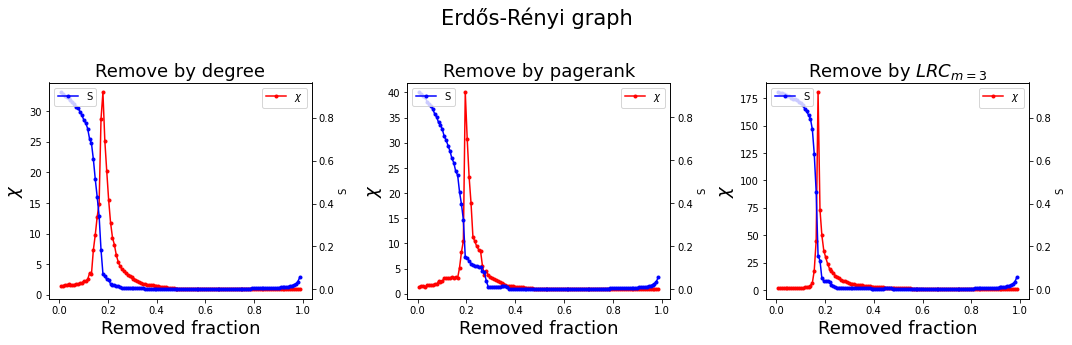

In [10]:
fig_ER,ax_ER = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
fig_ER.suptitle('Erdős-Rényi graph',fontsize = FONT_SIZE+3)

#Degree:
ax_ER[0].plot(deg_f_ER,deg_khi_ER,'r.-',label='$\chi$')
ax_ER_deg2 = ax_ER[0].twinx()
ax_ER_deg2.plot(deg_f_ER,deg_GC_rel_size_ER,'b.-',label='S')
ax_ER_deg2.set_ylabel('S')
ax_ER[0].set_title('Remove by degree',fontsize=FONT_SIZE)
ax_ER[0].set_xlabel('Removed fraction',fontsize=FONT_SIZE)
ax_ER[0].set_ylabel(r'$\chi$',fontsize=FONT_SIZE)
ax_ER[0].legend()
ax_ER_deg2.legend(loc ='upper left')

#Page rank:
ax_ER[1].plot(prank_f_ER,prank_khi_ER,'r.-',label='$\chi$')
ax_ER_prank2 = ax_ER[1].twinx()
ax_ER_prank2.plot(prank_f_ER,prank_GC_rel_size_ER,'b.-',label='S')
ax_ER_prank2.set_ylabel('S')
ax_ER[1].set_title('Remove by pagerank',fontsize=FONT_SIZE)
ax_ER[1].set_xlabel('Removed fraction',fontsize=FONT_SIZE)
ax_ER[1].set_ylabel(r'$\chi$',fontsize=FONT_SIZE)
ax_ER[1].legend()
ax_ER_prank2.legend(loc ='upper left')

#Degree:
ax_ER[2].plot(LRCm3_f_ER,LRCm3_khi_ER,'r.-',label='$\chi$')
ax_ER_LRCm3_2 = ax_ER[2].twinx()
ax_ER_LRCm3_2.plot(LRCm3_f_ER,LRCm3_GC_rel_size_ER,'b.-',label='S')
ax_ER_LRCm3_2.set_ylabel('S')
ax_ER[2].set_title('Remove by $LRC_{m=3}$',fontsize=FONT_SIZE)
ax_ER[2].set_xlabel('Removed fraction',fontsize=FONT_SIZE)
ax_ER[2].set_ylabel(r'$\chi$',fontsize=FONT_SIZE)
ax_ER[2].legend()
ax_ER_LRCm3_2.legend(loc ='upper left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(path_pic+'edge_remove_ER.jpg',dpi=200)

# Barabási - Albert graph:

In [11]:
deg_khi_BA = []
deg_GC_rel_size_BA = []
deg_f_BA = []

# betw_khi_BA = []
# betw_GC_rel_size_BA = []
# betw_f_BA = []

LRCm3_khi_BA = []
LRCm3_GC_rel_size_BA = []
LRCm3_f_BA = []

prank_khi_BA = []
prank_GC_rel_size_BA = []
prank_f_BA = []

network_BA_copy = network_BA.copy()
steps = 10


while network_BA_copy.number_of_nodes() > 2*steps:
    network_BA_copy = node_remove_by_degree(network_BA_copy,nr_nodes_to_remove=steps)
    chi,s = Calc_chi_and_S(network_BA_copy)

    deg_khi_BA.append(chi)
    deg_GC_rel_size_BA.append(s)
    deg_f_BA.append((network_BA.number_of_nodes() - network_BA_copy.number_of_nodes()) / network_BA.number_of_nodes())
print('Degree removing done.')

network_BA_copy = network_BA.copy()

while network_BA_copy.number_of_nodes() > 2*steps:
    network_BA_copy = node_remove_by_page_rank(network_BA_copy,nr_nodes_to_remove=steps)
    chi,s = Calc_chi_and_S(network_BA_copy)

    prank_khi_BA.append(chi)
    prank_GC_rel_size_BA.append(s)
    prank_f_BA.append((network_BA.number_of_nodes() - network_BA_copy.number_of_nodes()) / network_BA.number_of_nodes())
print('Page rank removing done.')

network_BA_copy = network_BA.copy()

while network_BA_copy.number_of_nodes() > 2*steps:
    network_BA_copy = node_remove_by_LRC_m3(network_BA_copy,nr_nodes_to_remove=steps)
    chi,s = Calc_chi_and_S(network_BA_copy)

    LRCm3_khi_BA.append(chi)
    LRCm3_GC_rel_size_BA.append(s)
    LRCm3_f_BA.append((network_BA.number_of_nodes() - network_BA_copy.number_of_nodes()) / network_BA.number_of_nodes())

print('LRC_m3 removing done.')

# network_BA_copy = network_BA.copy()

# while network_BA_copy.number_of_nodes() > 2*steps:
#     network_BA_copy = node_remove_by_betweenness(network_BA_copy,nr_nodes_to_remove=steps)
#     chi,s = Calc_chi_and_S(network_BA_copy)

#     betw_khi_BA.append(chi)
#     betw_GC_rel_size_BA.append(s)
#     betw_f_BA.append((network_BA.number_of_nodes() - network_BA_copy.number_of_nodes()) / network_BA.number_of_nodes())

# print('Betweenness removing done.')

Degree removing done.
Page rank removing done.
LRC_m3 removing done.


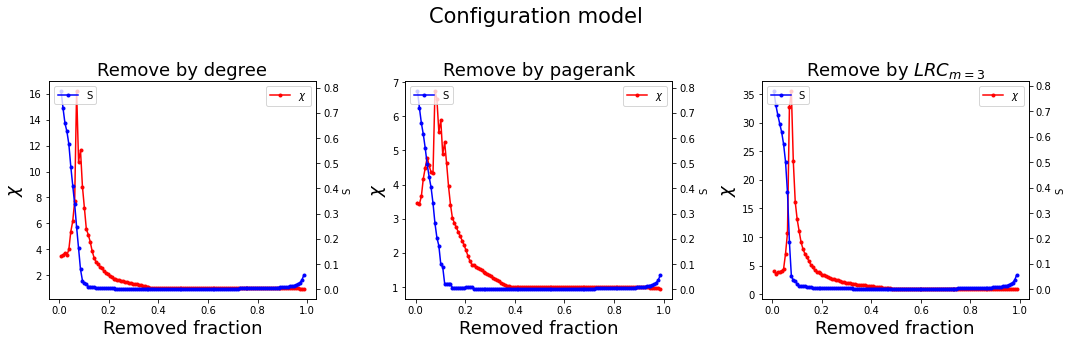

In [12]:
fig_BA,ax_BA = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
fig_BA.suptitle('Configuration model',fontsize=FONT_SIZE+3)
#Degree:
ax_BA[0].plot(deg_f_BA,deg_khi_BA,'r.-',label='$\chi$')
ax_BA_deg2 = ax_BA[0].twinx()
ax_BA_deg2.plot(deg_f_BA,deg_GC_rel_size_BA,'b.-',label='S')
ax_BA_deg2.set_ylabel('S')
ax_BA[0].set_title('Remove by degree',fontsize=FONT_SIZE)
ax_BA[0].set_xlabel('Removed fraction',fontsize=FONT_SIZE)
ax_BA[0].set_ylabel(r'$\chi$',fontsize=FONT_SIZE)
ax_BA[0].legend()
ax_BA_deg2.legend(loc ='upper left')

#Page rank:
ax_BA[1].plot(prank_f_BA,prank_khi_BA,'r.-',label='$\chi$')
ax_BA_prank2 = ax_BA[1].twinx()
ax_BA_prank2.plot(prank_f_BA,prank_GC_rel_size_BA,'b.-',label='S')
ax_BA_prank2.set_ylabel('S')
ax_BA[1].set_title('Remove by pagerank',fontsize=FONT_SIZE)
ax_BA[1].set_xlabel('Removed fraction',fontsize=FONT_SIZE)
ax_BA[1].set_ylabel(r'$\chi$',fontsize=FONT_SIZE)
ax_BA[1].legend()
ax_BA_prank2.legend(loc ='upper left')

#Degree:
ax_BA[2].plot(LRCm3_f_BA,LRCm3_khi_BA,'r.-',label='$\chi$')
ax_BA_LRCm3_2 = ax_BA[2].twinx()
ax_BA_LRCm3_2.plot(LRCm3_f_BA,LRCm3_GC_rel_size_BA,'b.-',label='S')
ax_BA_LRCm3_2.set_ylabel('S')
ax_BA[2].set_title('Remove by $LRC_{m=3}$',fontsize=FONT_SIZE)
ax_BA[2].set_xlabel('Removed fraction',fontsize=FONT_SIZE)
ax_BA[2].set_ylabel(r'$\chi$',fontsize=FONT_SIZE)
ax_BA[2].legend()
ax_BA_LRCm3_2.legend(loc ='upper left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(path_pic+'edge_remove_BA.jpg',dpi=200)

# Yeast

In [13]:
deg_khi_yeast = []
deg_GC_rel_size_yeast = []
deg_f_yeast = []

# betw_khi_yeast = []
# betw_GC_rel_size_yeast = []
# betw_f_yeast = []

LRCm3_khi_yeast = []
LRCm3_GC_rel_size_yeast = []
LRCm3_f_yeast = []

prank_khi_yeast = []
prank_GC_rel_size_yeast = []
prank_f_yeast = []

network_yeast_copy = network_yeast.copy()
steps = 10


while network_yeast_copy.number_of_nodes() > 2*steps:
    network_yeast_copy = node_remove_by_degree(network_yeast_copy,nr_nodes_to_remove=steps)
    chi,s = Calc_chi_and_S(network_yeast_copy)

    deg_khi_yeast.append(chi)
    deg_GC_rel_size_yeast.append(s)
    deg_f_yeast.append((network_yeast.number_of_nodes() - network_yeast_copy.number_of_nodes()) / network_yeast.number_of_nodes())
print('Degree removing done.')

network_yeast_copy = network_yeast.copy()

while network_yeast_copy.number_of_nodes() > 2*steps:
    network_yeast_copy = node_remove_by_page_rank(network_yeast_copy,nr_nodes_to_remove=steps)
    chi,s = Calc_chi_and_S(network_yeast_copy)

    prank_khi_yeast.append(chi)
    prank_GC_rel_size_yeast.append(s)
    prank_f_yeast.append((network_yeast.number_of_nodes() - network_yeast_copy.number_of_nodes()) / network_yeast.number_of_nodes())
print('Page rank removing done.')

network_yeast_copy = network_yeast.copy()

while network_yeast_copy.number_of_nodes() > 2*steps:
    network_yeast_copy = node_remove_by_LRC_m3(network_yeast_copy,nr_nodes_to_remove=steps)
    chi,s = Calc_chi_and_S(network_yeast_copy)

    LRCm3_khi_yeast.append(chi)
    LRCm3_GC_rel_size_yeast.append(s)
    LRCm3_f_yeast.append((network_yeast.number_of_nodes() - network_yeast_copy.number_of_nodes()) / network_yeast.number_of_nodes())

print('LRC_m3 removing done.')

# network_BA_copy = network_BA.copy()

# while network_BA_copy.number_of_nodes() > 2*steps:
#     network_BA_copy = node_remove_by_betweenness(network_BA_copy,nr_nodes_to_remove=steps)
#     chi,s = Calc_chi_and_S(network_BA_copy)

#     betw_khi_BA.append(chi)
#     betw_GC_rel_size_BA.append(s)
#     betw_f_BA.append((network_BA.number_of_nodes() - network_BA_copy.number_of_nodes()) / network_BA.number_of_nodes())

# print('Betweenness removing done.')

Degree removing done.
Page rank removing done.
LRC_m3 removing done.


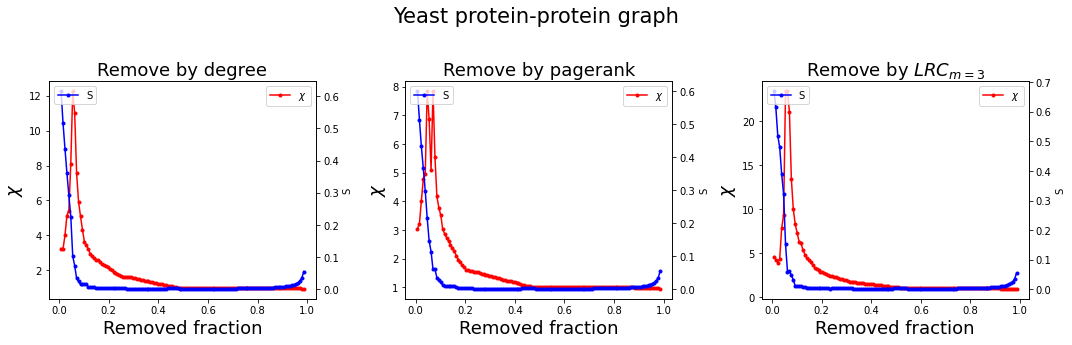

In [14]:
fig_yeast,ax_yeast = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
fig_yeast.suptitle('Yeast protein-protein graph',fontsize=FONT_SIZE+3)
#Degree:
ax_yeast[0].plot(deg_f_yeast,deg_khi_yeast,'r.-',label='$\chi$')
ax_yeast_deg2 = ax_yeast[0].twinx()
ax_yeast_deg2.plot(deg_f_yeast,deg_GC_rel_size_yeast,'b.-',label='S')
ax_yeast_deg2.set_ylabel('S')
ax_yeast[0].set_title('Remove by degree',fontsize=FONT_SIZE)
ax_yeast[0].set_xlabel('Removed fraction',fontsize=FONT_SIZE)
ax_yeast[0].set_ylabel(r'$\chi$',fontsize=FONT_SIZE)
ax_yeast[0].legend()
ax_yeast_deg2.legend(loc ='upper left')

#Page rank:
ax_yeast[1].plot(prank_f_yeast,prank_khi_yeast,'r.-',label='$\chi$')
ax_yeast_prank2 = ax_yeast[1].twinx()
ax_yeast_prank2.plot(prank_f_yeast,prank_GC_rel_size_yeast,'b.-',label='S')
ax_yeast_prank2.set_ylabel('S')
ax_yeast[1].set_title('Remove by pagerank',fontsize=FONT_SIZE)
ax_yeast[1].set_xlabel('Removed fraction',fontsize=FONT_SIZE)
ax_yeast[1].set_ylabel(r'$\chi$',fontsize=FONT_SIZE)
ax_yeast[1].legend()
ax_yeast_prank2.legend(loc ='upper left')

#Degree:
ax_yeast[2].plot(LRCm3_f_yeast,LRCm3_khi_yeast,'r.-',label='$\chi$')
ax_yeast_LRCm3_2 = ax_yeast[2].twinx()
ax_yeast_LRCm3_2.plot(LRCm3_f_yeast,LRCm3_GC_rel_size_yeast,'b.-',label='S')
ax_yeast_LRCm3_2.set_ylabel('S')
ax_yeast[2].set_title('Remove by $LRC_{m=3}$',fontsize=FONT_SIZE)
ax_yeast[2].set_xlabel('Removed fraction',fontsize=FONT_SIZE)
ax_yeast[2].set_ylabel(r'$\chi$',fontsize=FONT_SIZE)
ax_yeast[2].legend()
ax_yeast_LRCm3_2.legend(loc ='upper left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(path_pic+'edge_remove_yeast_network.jpg',dpi=200)

# Random node removal

In [60]:
rnd_rem_khi_ER = []
rnd_rem_GC_rel_size_ER = []
rnd_rem_f_ER = []

rnd_rem_khi_BA = []
rnd_rem_GC_rel_size_BA = []
rnd_rem_f_BA = []

rnd_rem_khi_yeast = []
rnd_rem_GC_rel_size_yeast = []
rnd_rem_f_yeast = []

network_ER_copy = network_ER.copy()
steps = 10


while network_ER_copy.number_of_nodes() > 2*steps:
    network_ER_copy = node_remove_in_random_order(network_ER_copy,nr_nodes_to_remove=steps)
    chi,s = Calc_chi_and_S(network_ER_copy)

    rnd_rem_khi_ER.append(chi)
    rnd_rem_GC_rel_size_ER.append(s)
    rnd_rem_f_ER.append((network_ER.number_of_nodes() - network_ER_copy.number_of_nodes()) / network_ER.number_of_nodes())
print('ER random removing done.')


network_BA_copy = network_BA.copy()
steps = 10

while network_BA_copy.number_of_nodes() > 2*steps:
    network_BA_copy = node_remove_in_random_order(network_BA_copy,nr_nodes_to_remove=steps)
    chi,s = Calc_chi_and_S(network_BA_copy)

    rnd_rem_khi_BA.append(chi)
    rnd_rem_GC_rel_size_BA.append(s)
    rnd_rem_f_BA.append((network_BA.number_of_nodes() - network_BA_copy.number_of_nodes()) / network_BA.number_of_nodes())
print('BA random removing done.')


network_yeast_copy = network_yeast.copy()
steps = 10

while network_yeast_copy.number_of_nodes() > 2*steps:
    network_yeast_copy = node_remove_in_random_order(network_yeast_copy,nr_nodes_to_remove=steps)
    chi,s = Calc_chi_and_S(network_yeast_copy)

    rnd_rem_khi_yeast.append(chi)
    rnd_rem_GC_rel_size_yeast.append(s)
    rnd_rem_f_yeast.append((network_yeast.number_of_nodes() - network_yeast_copy.number_of_nodes()) / network_yeast.number_of_nodes())
print('Yeast random removing done.')

ER random removing done.
BA random removing done.
Yeast random removing done.


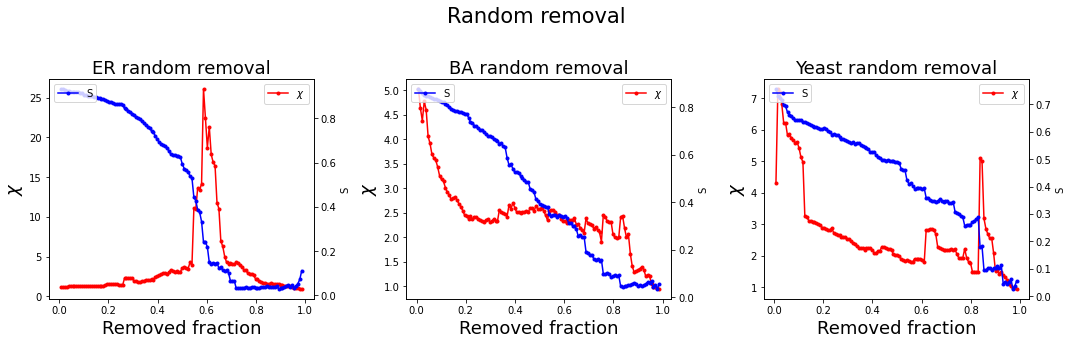

In [62]:
fig_rnd,ax_yeast = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
fig_rnd.suptitle('Random removal',fontsize=FONT_SIZE+3)
#ER:
ax_yeast[0].plot(rnd_rem_f_ER,rnd_rem_khi_ER,'r.-',label='$\chi$')
ax_yeast_deg2 = ax_yeast[0].twinx()
ax_yeast_deg2.plot(rnd_rem_f_ER,rnd_rem_GC_rel_size_ER,'b.-',label='S')
ax_yeast_deg2.set_ylabel('S')
ax_yeast[0].set_title('ER random removal',fontsize=FONT_SIZE)
ax_yeast[0].set_xlabel('Removed fraction',fontsize=FONT_SIZE)
ax_yeast[0].set_ylabel(r'$\chi$',fontsize=FONT_SIZE)
ax_yeast[0].legend()
ax_yeast_deg2.legend(loc ='upper left')

#Page rank:
ax_yeast[1].plot(rnd_rem_f_BA,rnd_rem_khi_BA,'r.-',label='$\chi$')
ax_yeast_prank2 = ax_yeast[1].twinx()
ax_yeast_prank2.plot(rnd_rem_f_BA,rnd_rem_GC_rel_size_BA,'b.-',label='S')
ax_yeast_prank2.set_ylabel('S')
ax_yeast[1].set_title('BA random removal',fontsize=FONT_SIZE)
ax_yeast[1].set_xlabel('Removed fraction',fontsize=FONT_SIZE)
ax_yeast[1].set_ylabel(r'$\chi$',fontsize=FONT_SIZE)
ax_yeast[1].legend()
ax_yeast_prank2.legend(loc ='upper left')

#Degree:
ax_yeast[2].plot(rnd_rem_f_yeast,rnd_rem_khi_yeast,'r.-',label='$\chi$')
ax_yeast_LRCm3_2 = ax_yeast[2].twinx()
ax_yeast_LRCm3_2.plot(rnd_rem_f_yeast,rnd_rem_GC_rel_size_yeast,'b.-',label='S')
ax_yeast_LRCm3_2.set_ylabel('S')
ax_yeast[2].set_title('Yeast random removal',fontsize=FONT_SIZE)
ax_yeast[2].set_xlabel('Removed fraction',fontsize=FONT_SIZE)
ax_yeast[2].set_ylabel(r'$\chi$',fontsize=FONT_SIZE)
ax_yeast[2].legend()
ax_yeast_LRCm3_2.legend(loc ='upper left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(path_pic+'random_node_remove_all_networks.jpg',dpi=200)

# Summary

The change in the relative size of the giant component tells us, the scale-free networks fall apart very soon, if we target the most important nodes in the removing process. In the case of ER graph this happens much later.

The real system's behaviour is similar to the BA graph. Actually the yeast network is scale-free too.
The impact of the three quantities are similar to each other, both of them can describe the importance of nodes.

The peaks in the susceptibilitys mean phase transitions in the systems, which happens when the relative size of the giant component falls the most.

The random node removal, or model of random error shows us, random graphs fall apart if we remove enough node. However the relative size of the BA and yeast networks remains on a greater ratio.